In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [2]:
def load_coffee_data():
    """ Creates a coffee roasting data set.
        roasting duration: 12-15 minutes is best
        temperature range: 175-260C is best
    """
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1,2)
    X[:,1] = X[:,1] * 4 + 11.5          # 12-15 min is best
    X[:,0] = X[:,0] * (285-150) + 150  # 350-500 F (175-260 C) is best
    Y = np.zeros(len(X))
    
    i=0
    for t,d in X:
        y = -3/(260-175)*t + 21
        if (t > 175 and t < 260 and d > 12 and d < 15 and d<=y ):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1

    return (X, Y.reshape(-1,1))

In [21]:
X, Y = load_coffee_data()
X = X.reshape(-1,2)
Y = Y.reshape(-1,1)
print(X.reshape(-1,2).shape, Y.shape)

(200, 2) (200, 1)


In [22]:
print(f"X[0:3] = {X[0]}, Y[0] = {Y[0]}")

X[0:3] = [185.31763812  12.69396457], Y[0] = [1.]


In [49]:
pos = Y == 1
neg = Y == 0
pos = pos.reshape(-1)
neg = neg.reshape(-1)

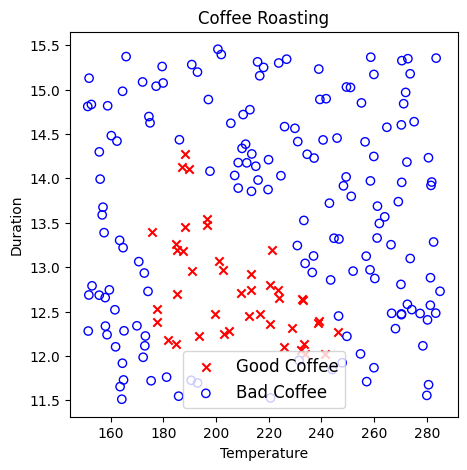

In [55]:
fig, ax = plt.subplots(1, 1, figsize = (5,5))
ax.scatter(X[pos,0], X[pos,1], marker = 'x', color = 'red', label='Good Coffee')
ax.scatter(X[neg,0], X[neg,1], marker = 'o', color = 'blue', facecolor='none', label='Bad Coffee')
ax.legend(fontsize='large')
ax.set_xlabel('Temperature')
ax.set_ylabel('Duration')
ax.set_title('Coffee Roasting')
plt.show()

## Normalize data

In [58]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X)
Xn = norm_l(X)
print(f"Temperature Max, Min pre normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration Max, Min pre normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min pre normalization: 1.66, -1.69
Duration Max, Min pre normalization: 1.79, -1.70


Tile/copy our data to increase the training set size and reduce the number of training epochs.

In [60]:
Xt = np.tile(Xn,(1000,1))
Yt = np.tile(Y, (1000,1))
print(Xt.shape, Yt.shape)

(200000, 2) (200000, 1)


## Tensorflow model

In [61]:
tf.random.set_seed(1234)
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation='sigmoid', name='layer1'),
        Dense(1, activation='sigmoid', name='layer2')
    ]
)

In [62]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

In [63]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:)", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:)", b2)

W1(2, 3):
 [[-0.1631186   0.26397896  0.5480132 ]
 [ 1.083916   -0.9128633  -1.0841463 ]] 
b1(3,):) [0. 0. 0.]
W2(3, 1):
 [[-0.8313689 ]
 [ 0.46557522]
 [-0.33418804]] 
b2(1,):) [0.]


In [64]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    Xt, Yt,
    epochs=10
)

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 239us/step - loss: 0.3178
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1s 233us/step - loss: 0.1195
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1s 233us/step - loss: 0.0555
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1s 232us/step - loss: 0.0180
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1s 234us/step - loss: 0.0118
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1s 232us/step - loss: 0.0083
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1s 232us/step - loss: 0.0060
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1s 231us/step - loss: 0.0044
Epoch 9/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1s 235us/step - loss: 0.0032
Epoch 10/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 239us/step - loss: 0.0024


Updated Weights

In [65]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:)", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:)", b2)

W1(2, 3):
 [[ 1.4672219e+01  1.2832773e+01 -2.3584501e-03]
 [ 1.2273926e+01  2.9559609e-01 -9.1884346e+00]] 
b1(3,):) [  1.9084709  13.438024  -11.490253 ]
W2(3, 1):
 [[-43.43592 ]
 [ 39.95287 ]
 [-46.820057]] 
b2(1,):) [-12.804676]


In [66]:
W1 = np.array([
    [-8.94, 0.29, 12.89],
    [-0.17, -7.34, 10.79]
])
b1 = np.array([-9.87, -9.28, 1.01])

W2 = np.array([
    [-31.38],
    [-27.86],
    [-32.79]
])
b2 = np.array([15.54])

model.get_layer("layer1").set_weights([W1, b1])
model.get_layer("layer2").set_weights([W2, b2])

In [68]:
X_test = np.array([
    [200, 13.9],
    [200, 17]
]
)
X_testn = norm_l(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
predictions = 
 [[9.625127e-01]
 [3.031606e-08]]


To convert the probabilities to a decision, we apply a threshold

In [69]:
y_hat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        y_hat[i] = 1
    else:
        y_hat[i] = 0
print(f"decisions = \n{y_hat}")

decisions = 
[[1.]
 [0.]]


This can be accomplished more succintly:

In [70]:
y_hat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{y_hat}")

decisions = 
[[1]
 [0]]


## Learned about the steps involved in tensorflow implementation